# 美国大选地图 

美国历届总统选举结果地图

<b>US Shapefile:</b> https://alicia.data.socrata.com/Government/States-21basic/jhnu-yfrj/data <br>
<b>Election results:</b> https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/42MVDX

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt, mpld3
%matplotlib inline
import json
import datetime

from shapely.geometry import Polygon, mapping
import geopandas as gpd
import folium
from folium.plugins import TimeSliderChoropleth

import os

data_path = os.environ.get('pub_data')

## US Shape File

In [64]:
# Get US states shapefile
us_shape = gpd.read_file(data_path + '/States_shapefile/States_shapefile.shp')
us_shape = us_shape[['State_Name','geometry']]
us_shape.head()

,State_Name,geometry
0,ALABAMA,"POLYGON ((-85.07007 31.9807, -85.11515 31.9074..."
1,ALASKA,"MULTIPOLYGON (((-161.33379 58.73325, -161.3824..."
2,ARIZONA,"POLYGON ((-114.52063 33.02771, -114.55909 33.0..."
3,ARKANSAS,"POLYGON ((-94.46169 34.19677, -94.45262 34.508..."
4,CALIFORNIA,"MULTIPOLYGON (((-121.66522 38.16929, -121.7823..."


In [65]:
# plot the shape file with folium 
m = folium.Map(location=[50.77500, -100],zoom_start=3) 
choropleth =folium.GeoJson(data= us_shape.to_json())
m.add_child(choropleth)

In [66]:
# Get election data
election = pd.read_csv(data_path +  "/U.S. President 1976–2020/1976-2020-president.csv" )
election.replace('democratic-farmer-labor','democrat',inplace=True)
election.head()

,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party_detailed,writein,candidatevotes,totalvotes,version,notes,party_simplified
0,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"CARTER, JIMMY",DEMOCRAT,False,659170,1182850,20210113,NaN,DEMOCRAT
1,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"FORD, GERALD",REPUBLICAN,False,504070,1182850,20210113,NaN,REPUBLICAN
2,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"MADDOX, LESTER",AMERICAN INDEPENDENT PARTY,False,9198,1182850,20210113,NaN,OTHER
3,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"BUBAR, BENJAMIN """"BEN""""",PROHIBITION,False,6669,1182850,20210113,NaN,OTHER
4,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"HALL, GUS",COMMUNIST PARTY USE,False,1954,1182850,20210113,NaN,OTHER


In [67]:
# Transform election data 
states = set(election['state'])

results = {}
for year in range(1976,2024,4):
    
    result = {}
    for state in states:
        
        state_year = election[(election.year == year) 
                              & (election.state == state)]
        dem = max(state_year[state_year.party_simplified == 'DEMOCRAT']['candidatevotes'])
        rep = max(state_year[state_year.party_simplified == 'REPUBLICAN']['candidatevotes'])
        
        result[state] = {'dem':dem, 'rep':rep}
        
    results[year] = result
    
results

{1976: {'TEXAS': {'dem': 2082319, 'rep': 1953300},
  'WEST VIRGINIA': {'dem': 435864, 'rep': 314726},
  'INDIANA': {'dem': 1014714, 'rep': 1183958},
  'OKLAHOMA': {'dem': 532442, 'rep': 545708},
  'CALIFORNIA': {'dem': 3742284, 'rep': 3882244},
  'DISTRICT OF COLUMBIA': {'dem': 137818, 'rep': 27873},
  'DELAWARE': {'dem': 122461, 'rep': 109780},
  'GEORGIA': {'dem': 979409, 'rep': 483743},
  'MICHIGAN': {'dem': 1696714, 'rep': 1893742},
  'MAINE': {'dem': 232279, 'rep': 236320},
  'LOUISIANA': {'dem': 661365, 'rep': 587446},
  'SOUTH CAROLINA': {'dem': 450807, 'rep': 346149},
  'KANSAS': {'dem': 430421, 'rep': 502752},
  'SOUTH DAKOTA': {'dem': 147068, 'rep': 151505},
  'COLORADO': {'dem': 460801, 'rep': 584278},
  'IDAHO': {'dem': 126549, 'rep': 204151},
  'NEVADA': {'dem': 92479, 'rep': 101273},
  'NEW JERSEY': {'dem': 1444653, 'rep': 1509688},
  'PENNSYLVANIA': {'dem': 2328677, 'rep': 2205604},
  'ARIZONA': {'dem': 295602, 'rep': 418642},
  'NORTH CAROLINA': {'dem': 927365, 'rep': 7

## 2020 Results

In [68]:
def state_style(state,year,function=False):
    """
    Returns the style for a state in a given year
    """
    
    state_results = results[year][state]
    
    #Set state colour
    if state_results['dem'] >= state_results['rep']:
        color = '#4f7bff' #blue
    else:
        color = '#ff5b4f' #red
    
    #Set state style
    if function == False:
        # Format for style_dictionary
        state_style = {
            'opacity': 1,
            'color': color,
        } 
    else:
        # Format for style_fucntion
        state_style = {
             'fillOpacity': 1,
             'weight': 1,
             'fillColor': color,
             'color': '#000000'}    
  
    return state_style

def style_function(feature):
    """
    style_function used by the GeoJson folium function
    """

    state = feature['properties']['State_Name']
    style = state_style(state,year=2020,function=True)
    
    return style

In [69]:
# plot the choropleth 
m = folium.Map(location=[50.77500, -100],zoom_start=3) #Initialize map
choropleth =folium.GeoJson(data= us_shape.to_json(),style_function=style_function)
m.add_child(choropleth)

## Year Slider 

In [70]:
def year_to_ts(year):
    """
    Convert year to timestamp
    """
    time = datetime.datetime(year, 1, 1, 0, 0).strftime('%s')
    if len(time)==9: time ='0{}'.format(time)
    return time

def style_dictionary():
    """
    style_dictionary used by the TimeSliderChoropleth folium function
    """
    
    # get ids used by TimeSliderChoropleth
    ID = {}
    state_json = json.loads(us_shape.to_json())

    for state in state_json['features']:
        state_id = state['id']
        state_name = state['properties']['State_Name']
        ID[state_name] = state_id
    
    
    #create style dictionary
    style_dic= {}
    for state in states:
        
        state_dic = {}
        for year in range(1976,2024,4):
            
            time = year_to_ts(year)
            state_dic[time] =  state_style(state,year)

        style_dic[ID[state]] = state_dic  
        
    return style_dic

In [71]:
year_to_ts(2020)

'1577808000'

In [72]:
# Create time slider map
m = folium.Map(location=[50.77500, -100],zoom_start=3) 
ts = TimeSliderChoropleth(us_shape.to_json(), style_dictionary())
m.add_child(ts)

m.save("../figures/us_election_map1.html")

## State Buttons

In [73]:
def highlight_style(feature): 
    """
    style_function used when choropleth button
    is highighted
    """
    return {
        'fillOpacity': 0.2,
        'weight': 1,
        'fillColor': '#ffaf00',
        'color': '#000000'}  

def getFigure(state):
    """
    Plot voting trends from a given state
    """

    # Get number of votes
    years = range(1976,2024,4)
    dems = []
    reps =[]
    for year in years:

        result = results[year][state]
        dems.append(result['dem']/1000000)  
        reps.append(result['rep']/1000000) 

    # Plot number of votes    
    fig = plt.figure(figsize=(8,4))
    plt.plot(years,dems,label='Democrat',color='#4f7bff')
    plt.plot(years,reps,label='Republican',color='#ff5b4f')

    plt.title(state,size = 18)
    plt.ticklabel_format(style='plain')
    plt.xlabel('Year',size =14)
    plt.xticks(years)
    plt.ylabel('Votes (millions)',size =14)
    plt.legend(loc =0)

    # Add figure to iframe
    html = mpld3.fig_to_html(fig)
    iframe = folium.IFrame(html=html,width = 600, height = 300)

    return iframe

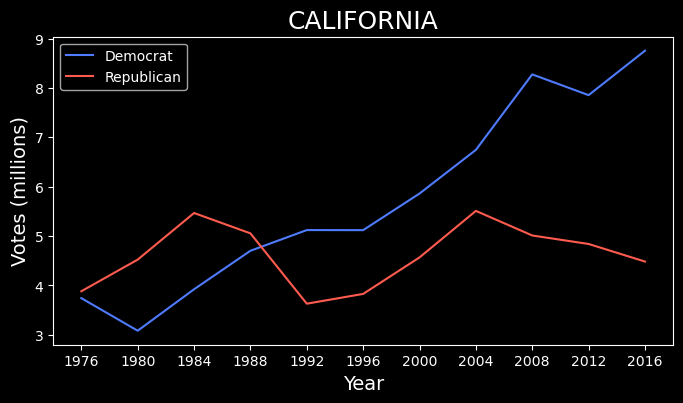

In [74]:
state = 'CALIFORNIA'

years = range(1976,2020,4)
dems = []
reps =[]
for year in years:

    result = results[year][state]
    dems.append(result['dem']/1000000)  
    reps.append(result['rep']/1000000) 

#Plot number of votes    
fig = plt.figure(figsize=(8,4))
plt.plot(years,dems,label='Democrat',color='#4f7bff')
plt.plot(years,reps,label='Republican',color='#ff5b4f')

plt.title(state,size = 18)
plt.ticklabel_format(style='plain')
plt.xlabel('Year',size =14)
plt.xticks(years)
plt.ylabel('Votes (millions)',size =14)
plt.legend(loc =0)

plt.savefig('../figures/california_trends.png',format='png',dpi=150)

/var/folders/h4/7cr1cmpn7v5b3x20_9wz8m740000gn/T/ipykernel_31452/1917717551.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(8,4))


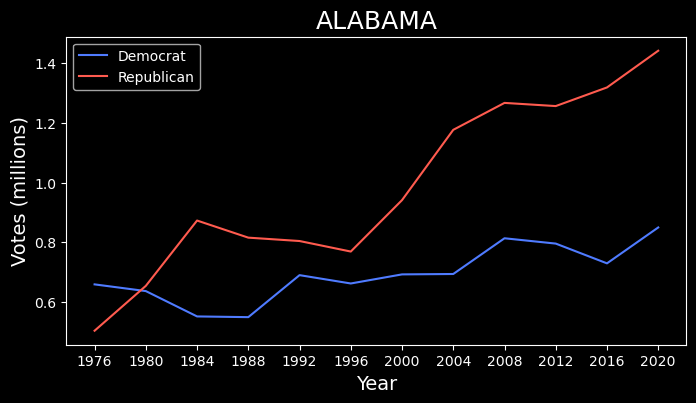

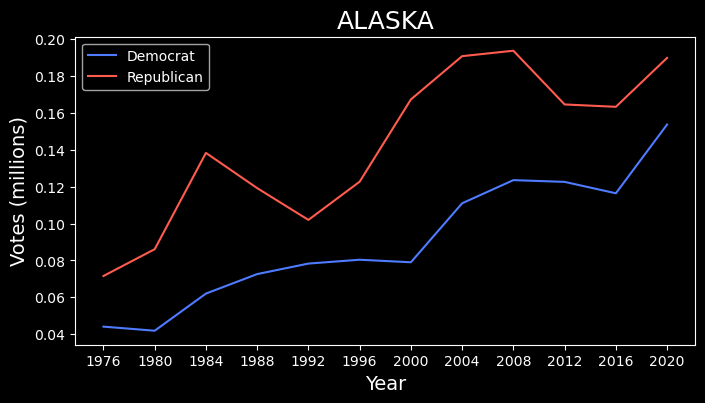

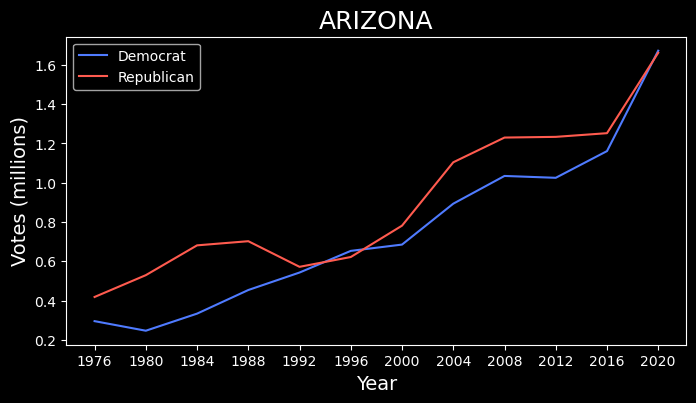

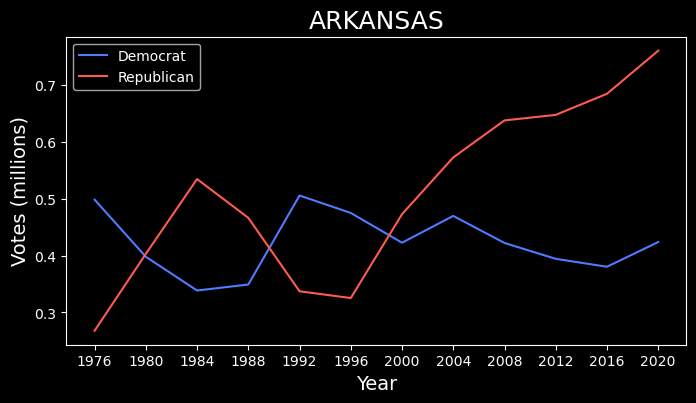

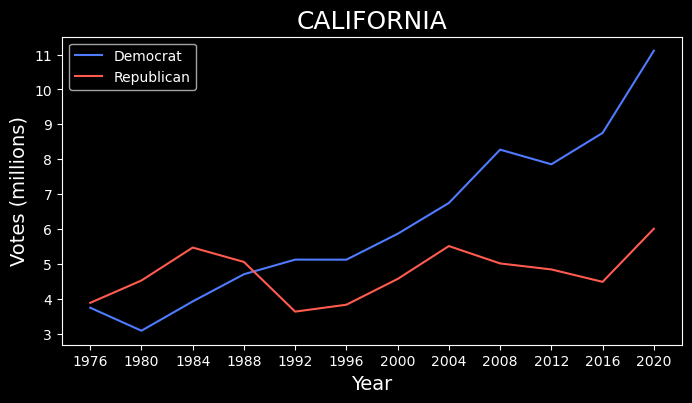

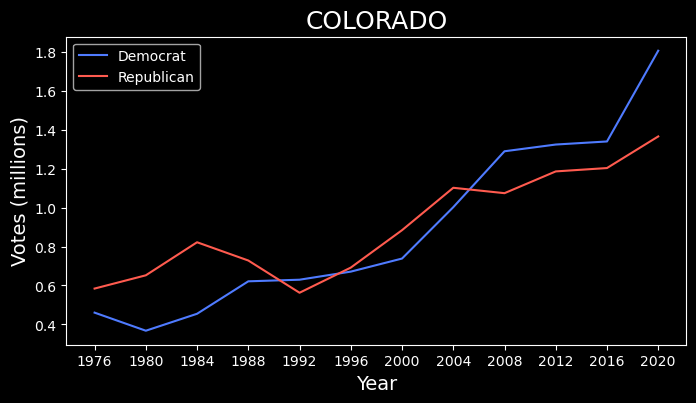

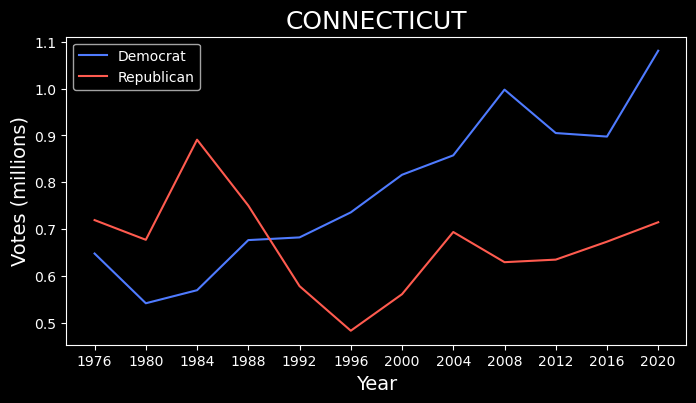

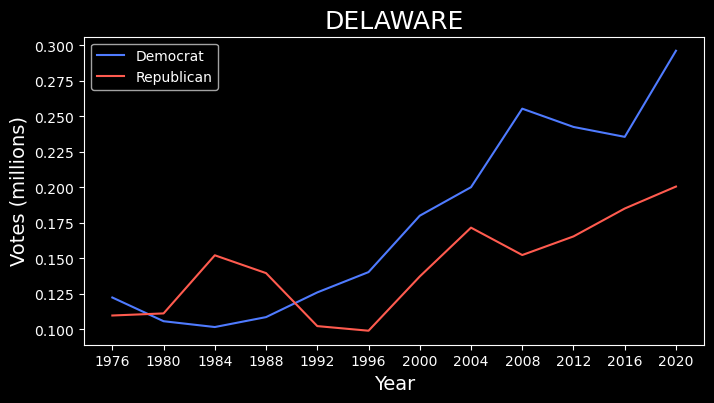

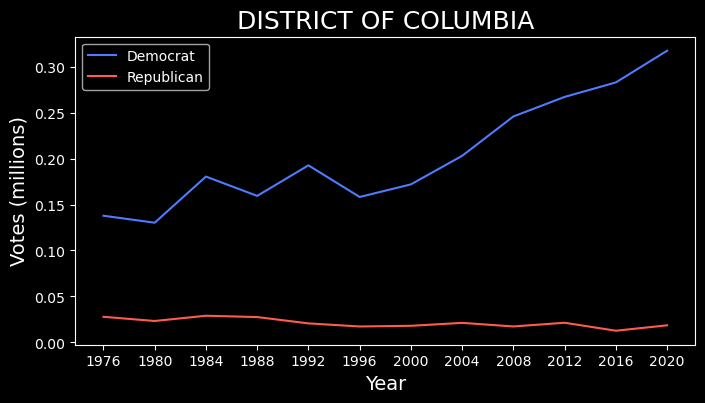

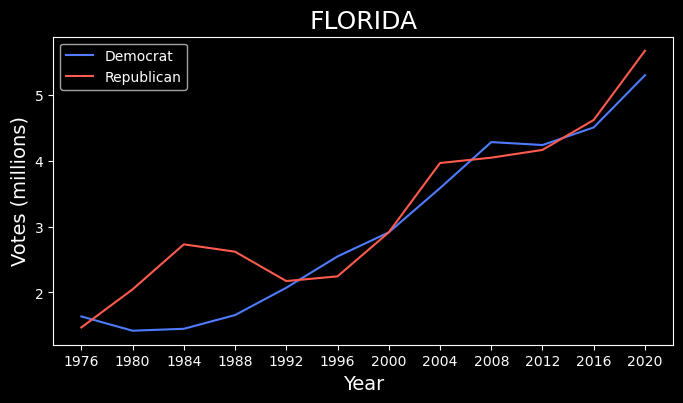

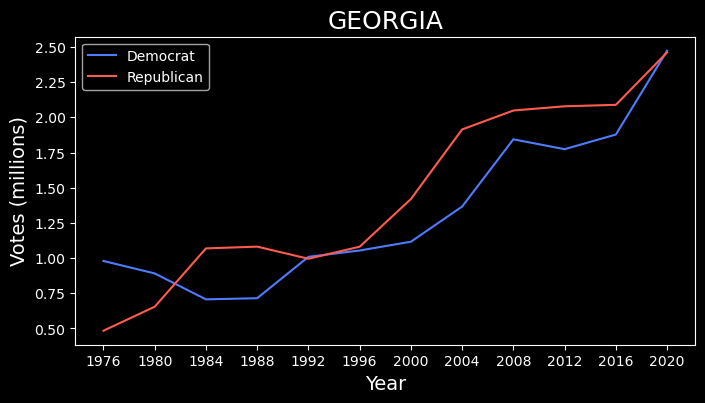

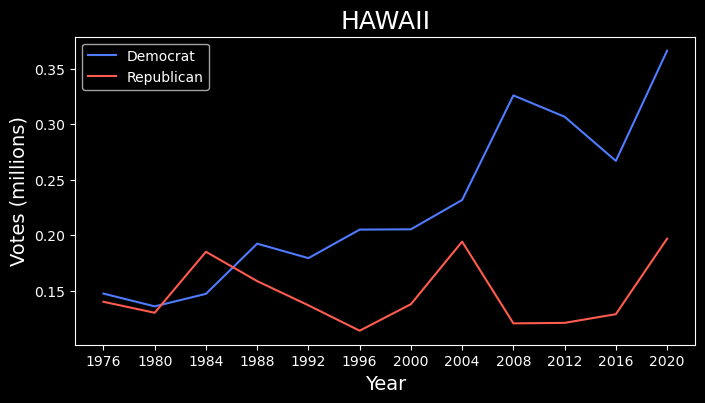

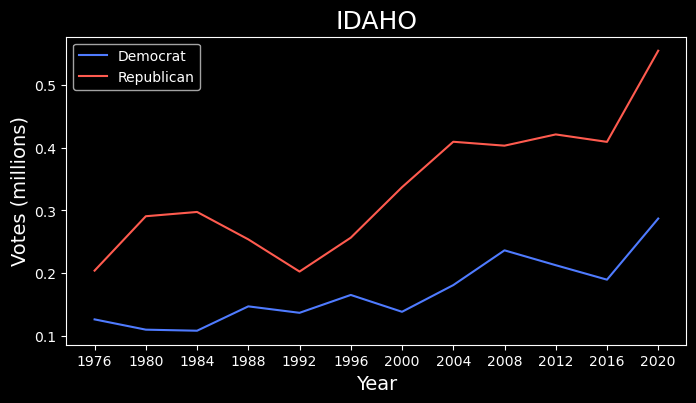

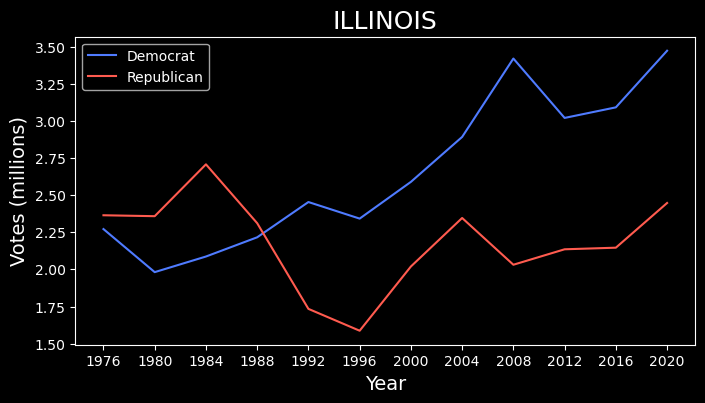

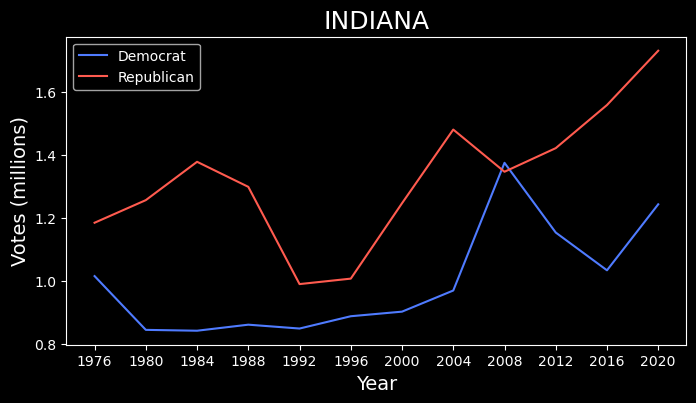

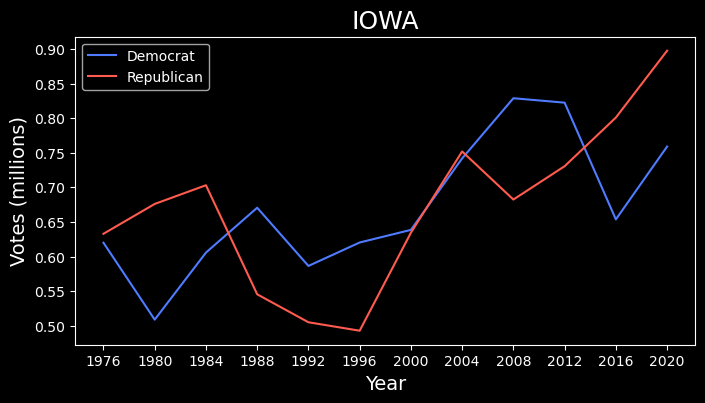

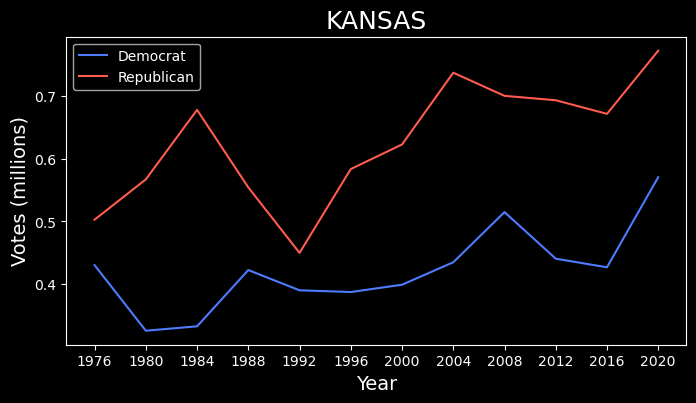

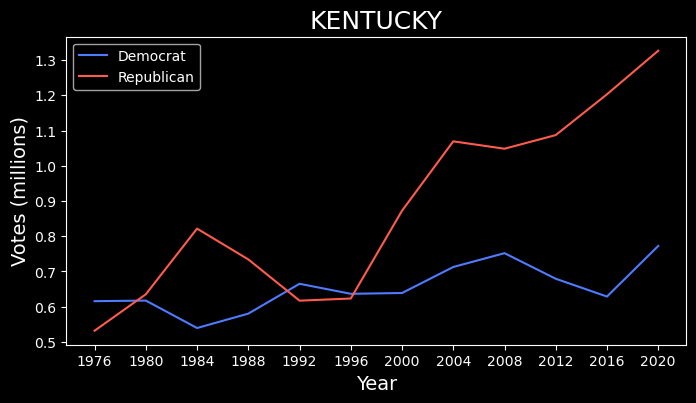

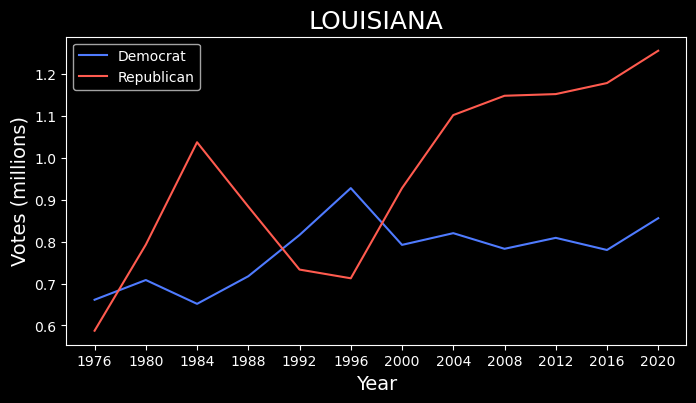

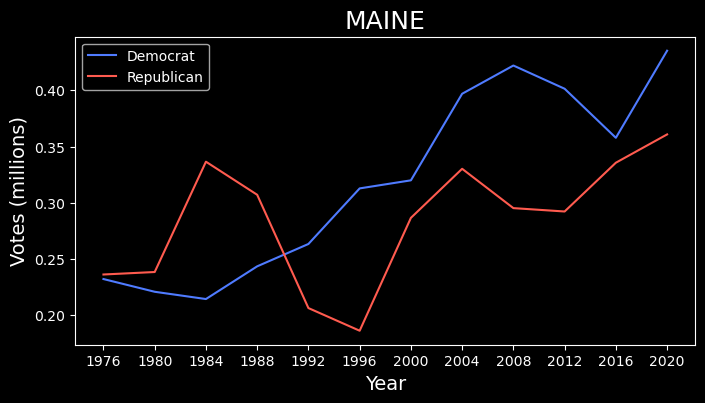

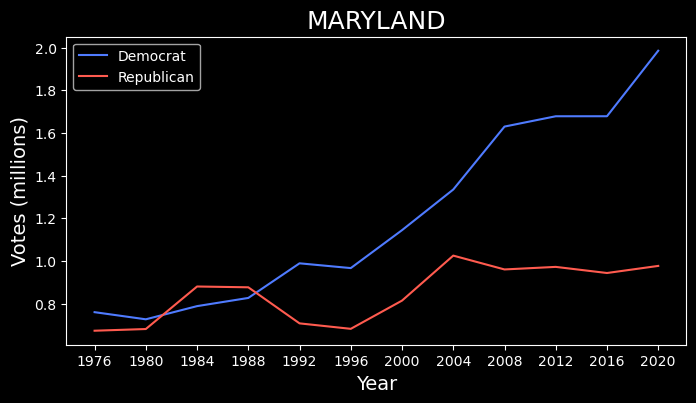

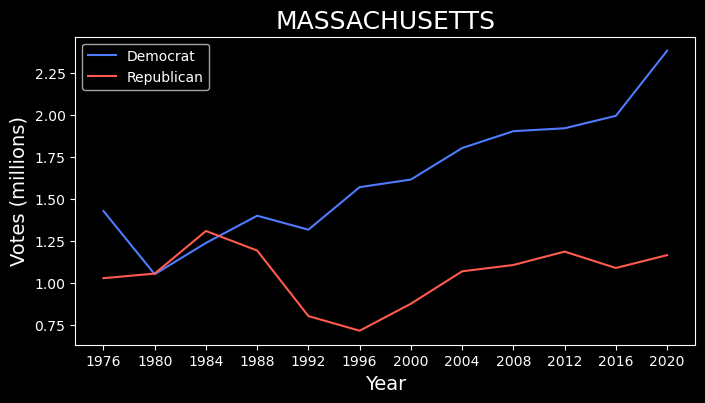

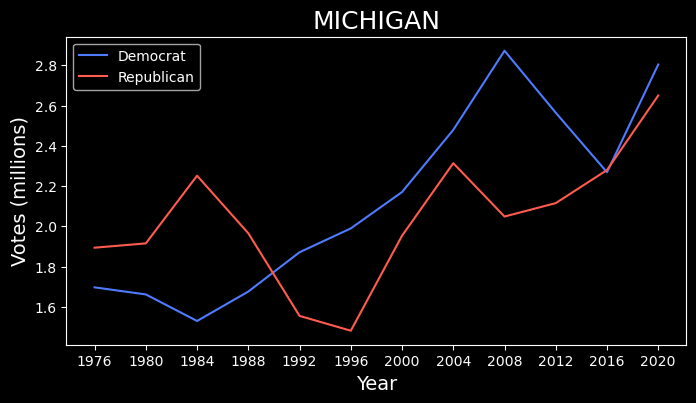

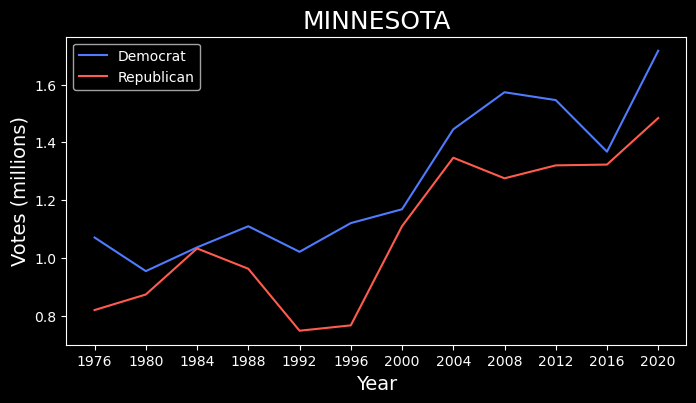

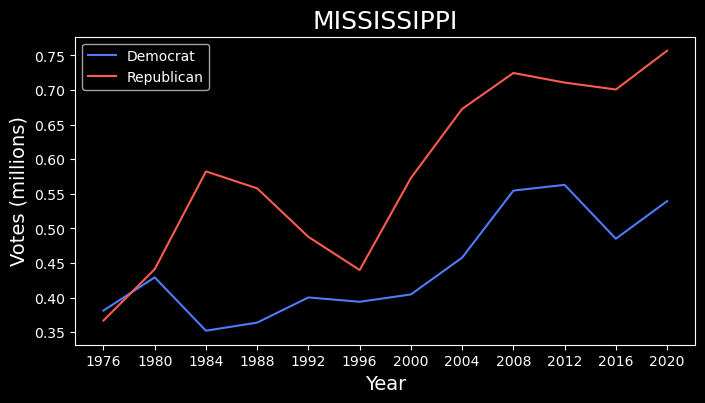

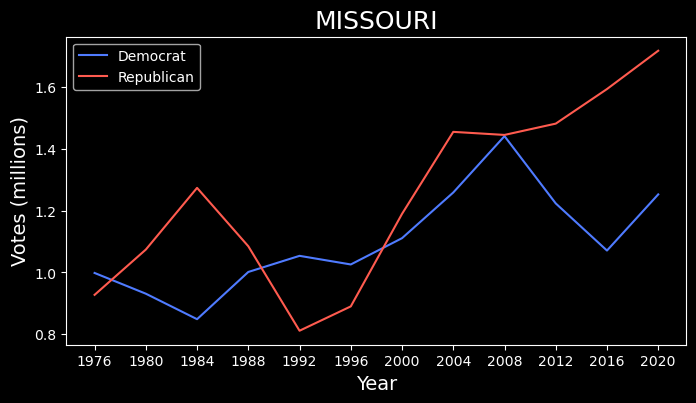

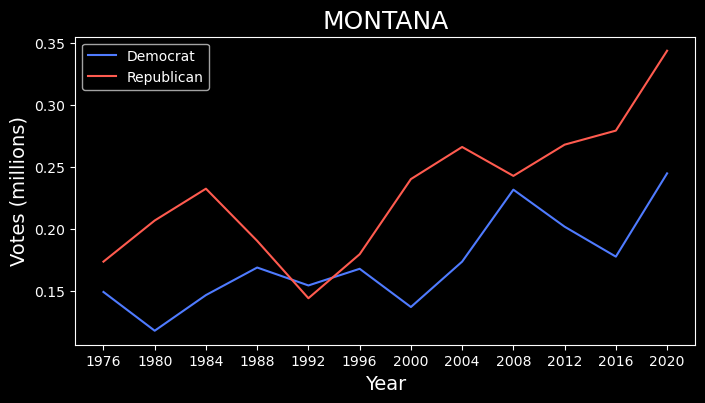

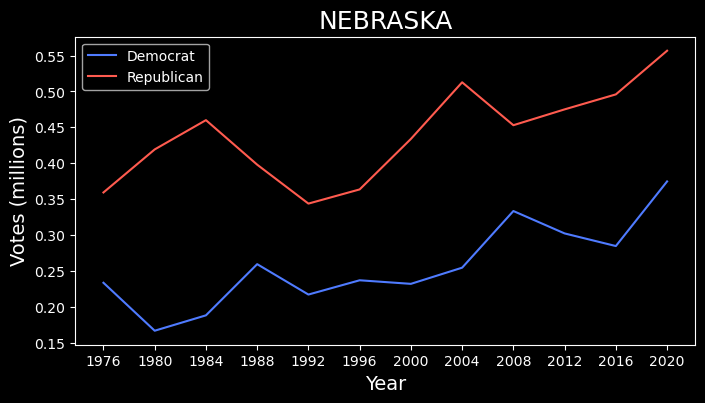

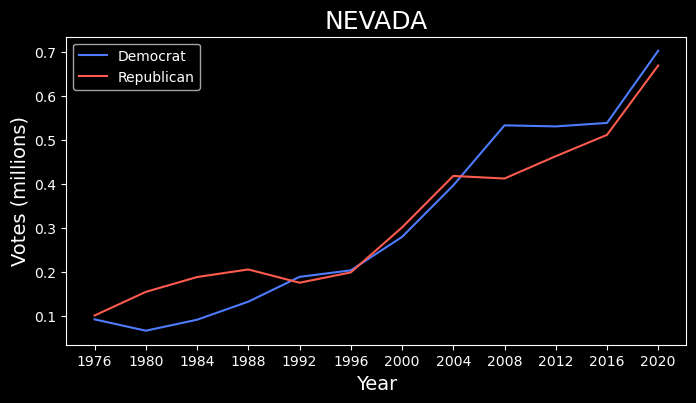

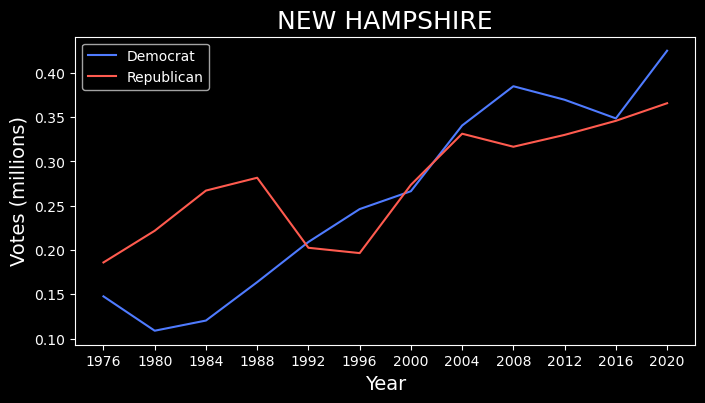

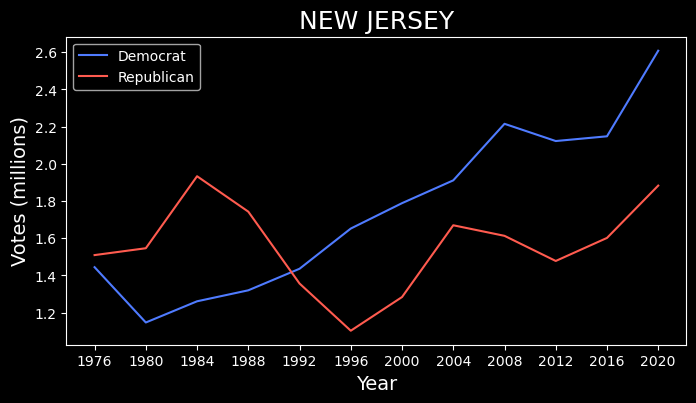

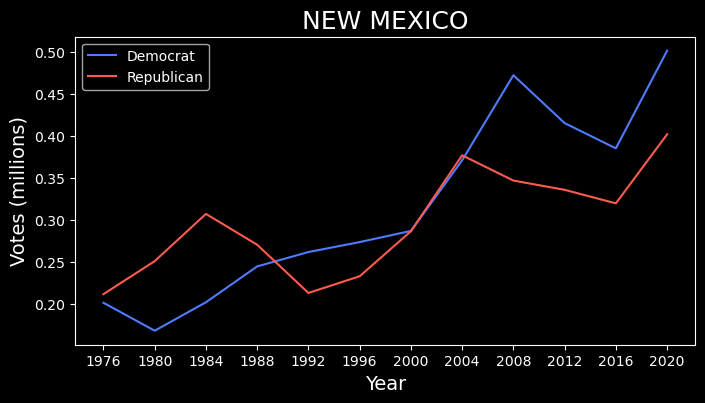

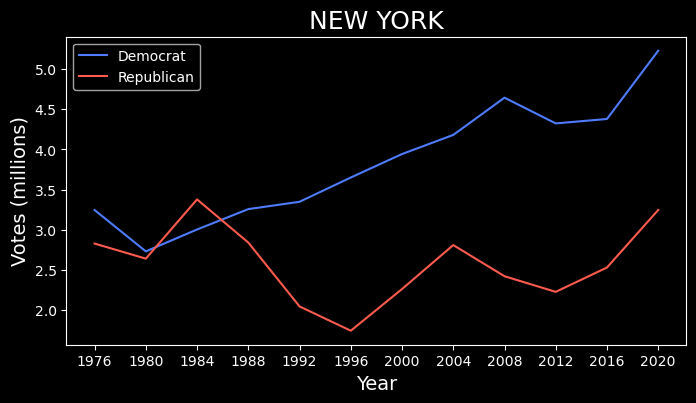

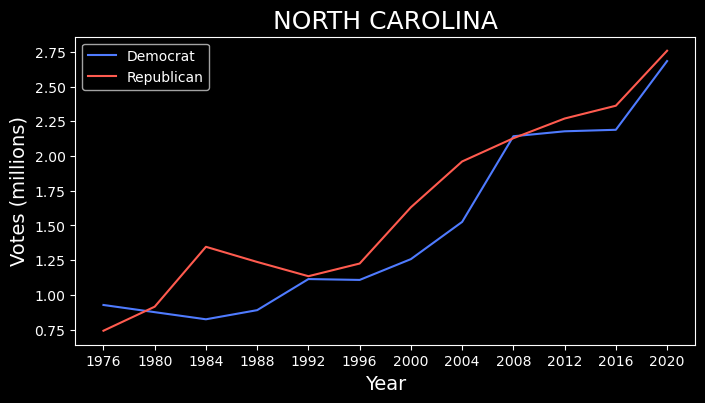

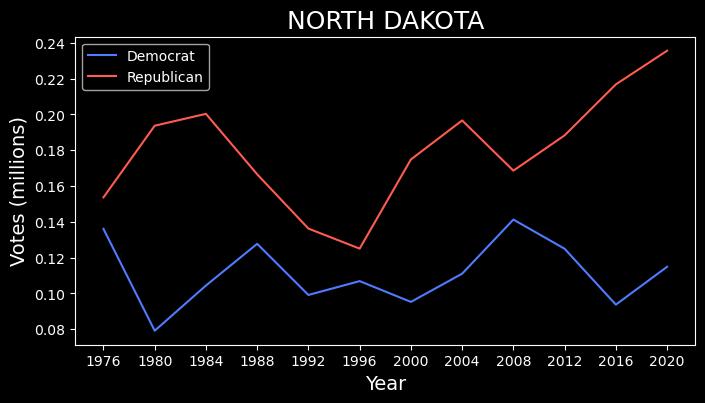

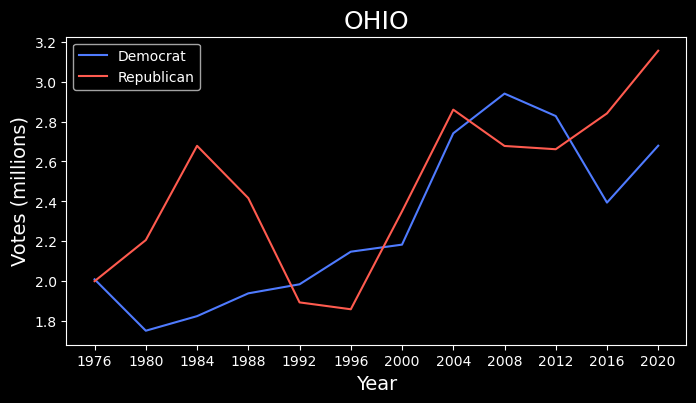

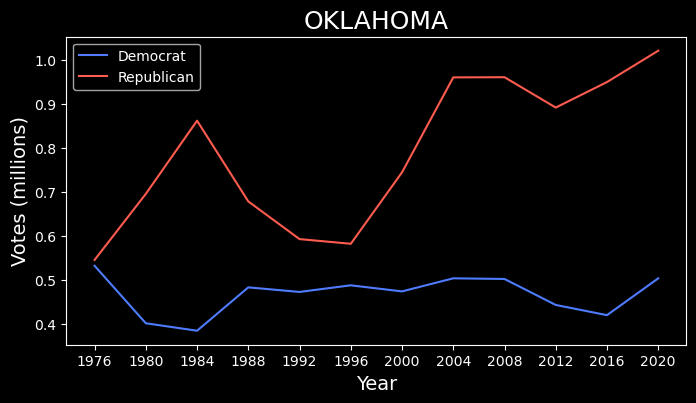

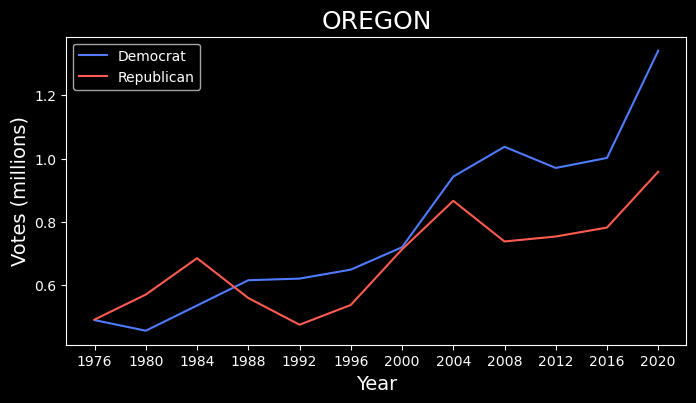

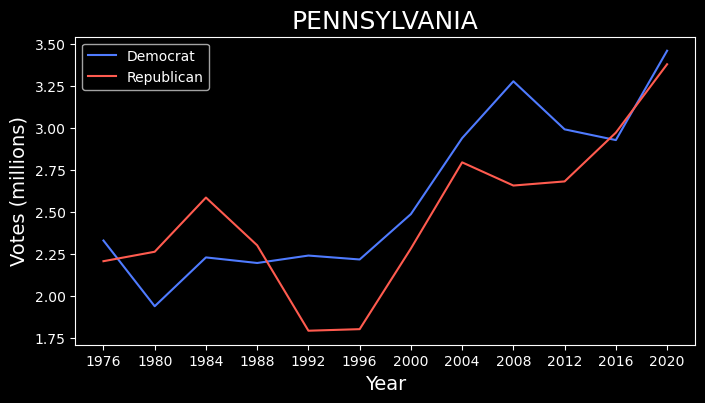

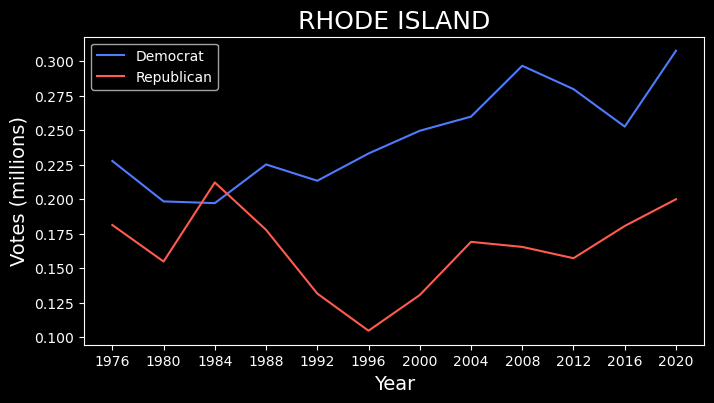

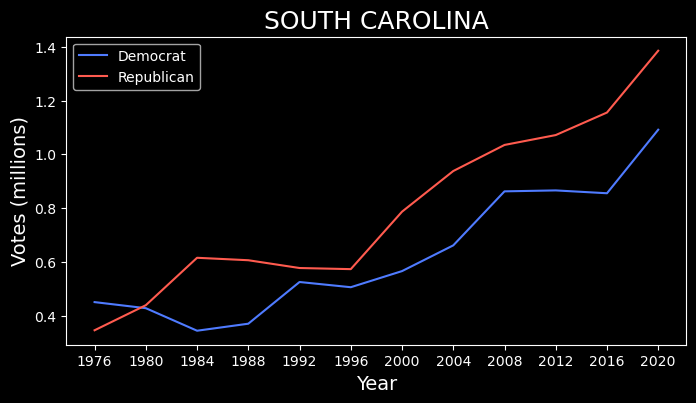

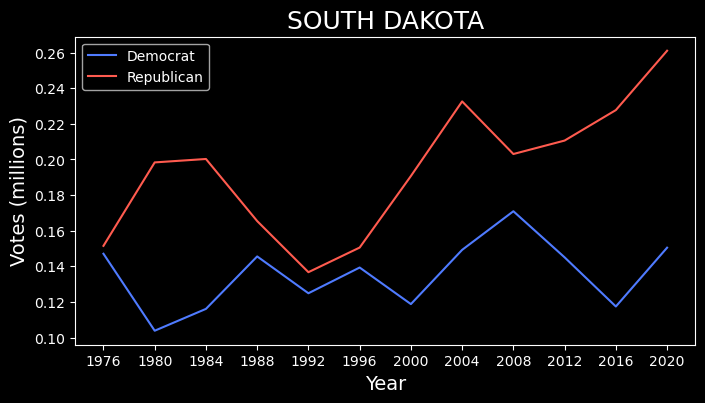

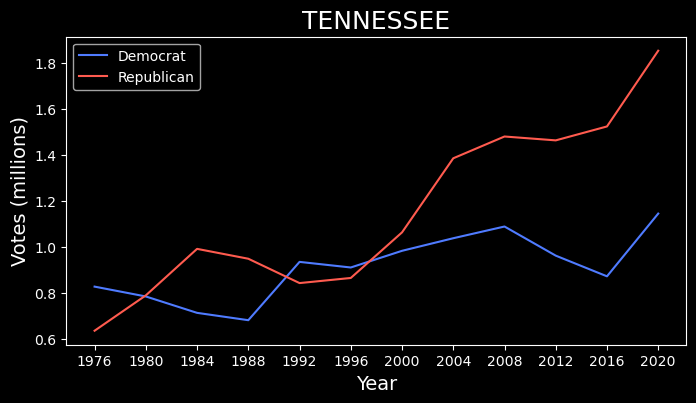

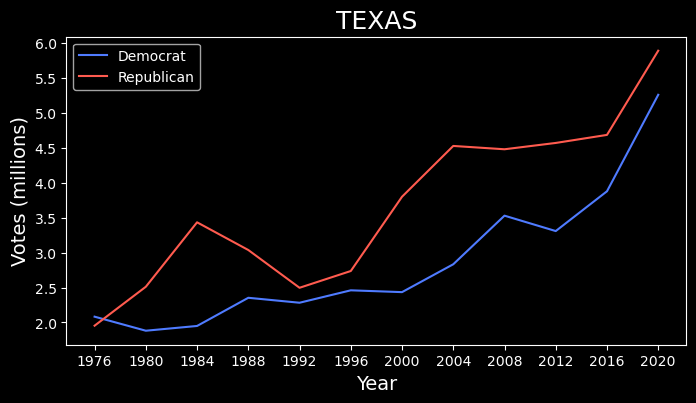

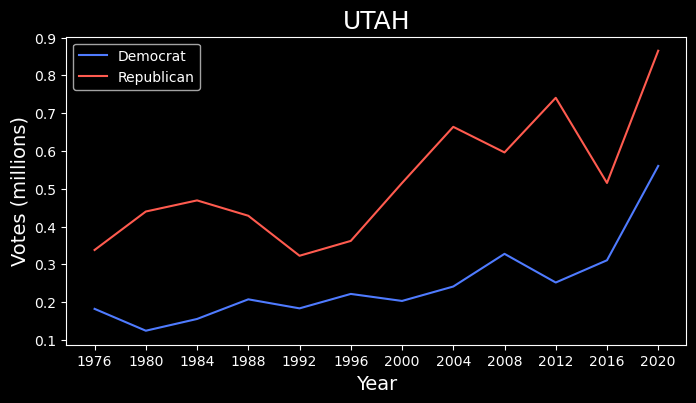

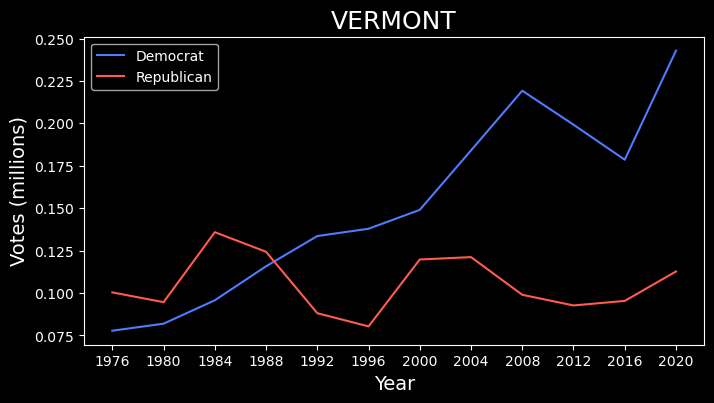

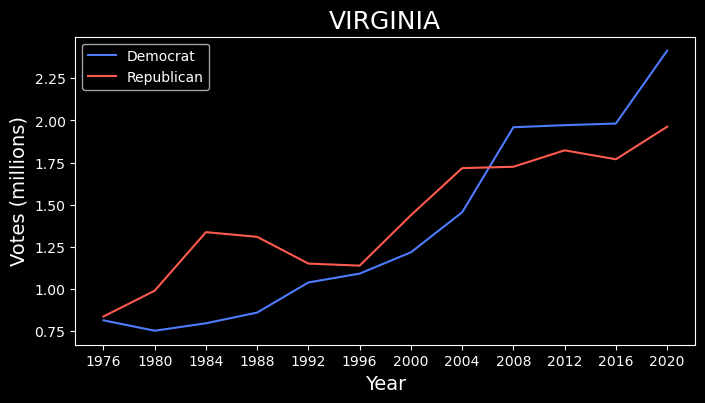

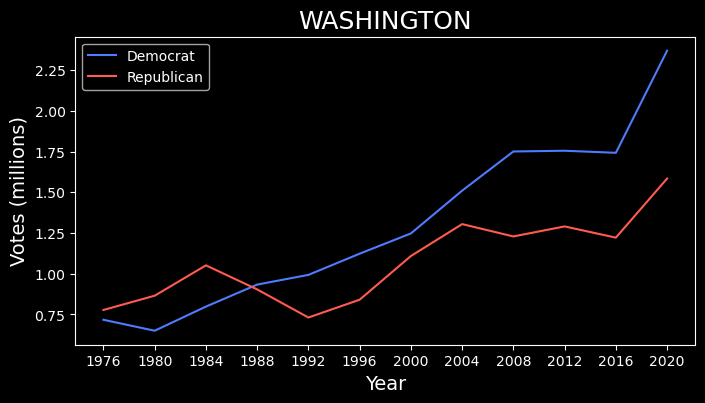

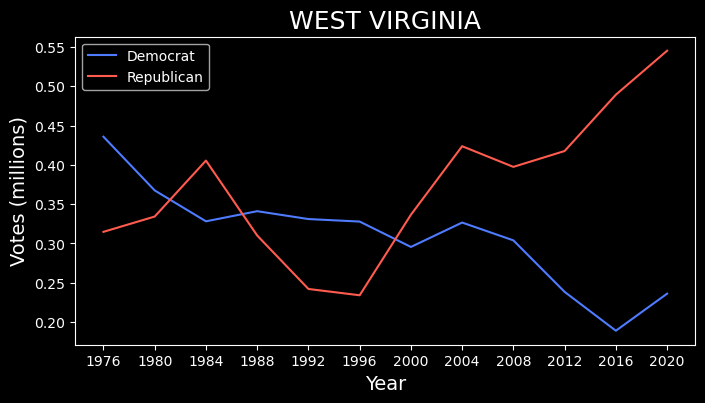

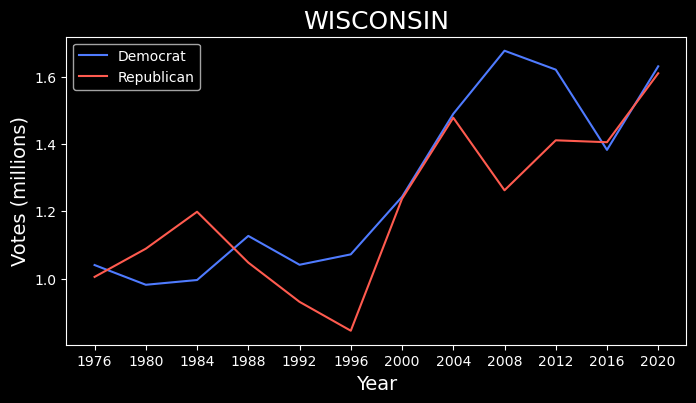

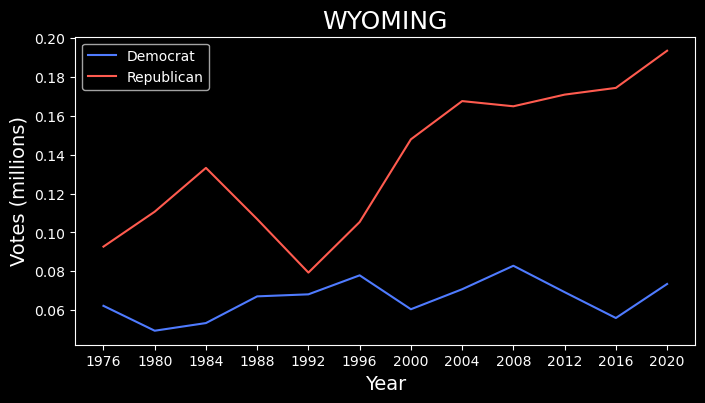

In [75]:
# plot the shape file with folium 
m = folium.Map(location=[50.77500, -100],zoom_start=5,max_zoom=5) # Initialize map
choropleth =folium.GeoJson(data=us_shape.to_json(),
                           style_function=style_function)
m.add_child(choropleth)

# Create popup button for each state
for i in range(len(us_shape)):
    geometry = us_shape.loc[i]['geometry']
    state_name = us_shape.loc[i]['State_Name']
    popup = folium.Popup(getFigure(state_name),max_width=1000)
    
    state_marker = folium.GeoJson(data=mapping(geometry),
                                  highlight_function=highlight_style)
    state_marker.add_child(popup)
    m.add_child(state_marker)

m.save("../figures/us_election_map2.html")